# Removing the unused vocabulary

In [3]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch

In [4]:
tokenizer = T5Tokenizer.from_pretrained("intfloat/multilingual-e5-base")
tokenizer

PreTrainedTokenizer(name_or_path='google/mt5-base', vocab_size=250100, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'})

In [37]:
model = T5ForConditionalGeneration.from_pretrained('intfloat/multilingual-e5-base')

You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


Our tokenizer contains 250K tokens, 

In [6]:
print(tokenizer.vocab_size)

250100


The model has 582M parameters. 

In [7]:
def msize(m):
    return sum(p.numel() for p in m.parameters())

original_size = msize(model)
print(msize(model))
print(msize(model.shared))
print('encoder')
print(msize(model.encoder))
print(msize(model.encoder.block))
print('decoder')
print(msize(model.decoder))
print(msize(model.decoder.block))
print(msize(model.lm_head))

582401280
192086016
encoder
277040256
84953472
decoder
305361024
113274240
192086016


Input and output embeddings are 66% of the whole model

In [9]:
print(msize(model.shared) / msize(model))
print(msize(model.lm_head) / msize(model))

0.32981729710484153
0.32981729710484153


# Determine the new tokens

Take a file from https://wortschatz.uni-leipzig.de/en/download/Russian as a representation of Russian language. It contains 1M sentences. 

Also take a similar representation of English, because we want our model to be bilingual, and English shares few tokens with Russian.

In [ ]:
!wget http://pcai056.informatik.uni-leipzig.de/downloads/corpora/rus-ru_web-public_2019_1M.tar.gz
!tar -xsvf rus-ru_web-public_2019_1M.tar.gz

In [ ]:
!wget http://pcai056.informatik.uni-leipzig.de/downloads/corpora/eng-com_web-public_2018_1M.tar.gz
!tar -xsvf eng-com_web-public_2018_1M.tar.gz

Let us look at the sentences

In [18]:
import pandas as pd
pd.options.display.max_colwidth = 300
import csv
fname = 'rus-ru_web-public_2019_1M/rus-ru_web-public_2019_1M-sentences.txt'
df_ru = pd.read_csv(fname, sep='\t', header=None, quoting=csv.QUOTE_NONE)
df_ru.columns = ['idx', 'text']
df_ru.sample(5)

,idx,text
53482,53483,"Больше Лена ничего говорить не стала, не до этого было."
937136,937137,"Чиновники наши не беднеют, а при наших доходах не разбогатеешь точно»."
401463,401464,"Кроме обязательной почты, сберкассы и трех магазинов РайПО, здесь функционируют объекты социальной инфраструктуры."
238656,238657,Доставка по России и ближнему зарубежью.
295958,295959,"Здесь раскинулась долина, в центре которой течет поток зеленовато‑голубого цвета шириной в несколько десятков метров, светящийся в темноте, как большой освещаемый изнутри бассейн."


In [19]:
fname = 'eng-com_web-public_2018_1M/eng-com_web-public_2018_1M-sentences.txt'
df_en = pd.read_csv(fname, sep='\t', header=None, quoting=csv.QUOTE_NONE)
df_en.columns = ['idx', 'text']
df_en.sample(5)

,idx,text
536627,536628,"My two crabby old men cats were not so impressed, but Miss Agnes DeMitten (aka Endora) was checking behind the monitor."
783178,783179,"There is another lightweight distribution, in the Ubuntu family called Xubuntu, but Lubuntu is far more efficient when it comes to memory usage."
447801,447802,"It's perfectly symmetric -- client to server, WinFS to Sharepoint."
207171,207172,"""Everything we asked for we got from Judge Lasnik,"" he said, and called on President Trump to make it ""unlawful for anyone to make this information available for anyone""."
595030,595031,"""People who are willing to do something like this, especially if the shark hasn't made it, are brought to justice,"" Spellman said."


Count the tokens that the current model uses for representing the sentences. 

In [20]:
from collections import Counter
from tqdm.auto import tqdm, trange

cnt_ru = Counter()
for text in tqdm(df_ru.text):
    cnt_ru.update(tokenizer.encode(text))

cnt_en = Counter()
for text in tqdm(df_en.text):
    cnt_en.update(tokenizer.encode(text))

In [23]:
cnt_en = Counter()
for text in tqdm(df_en.text):
    cnt_en.update(tokenizer.encode(text))

The tokens that are ever used with Russian are 23% of the whole vocabulary. With English, it is 27%.

Surprisingly, there is more than 50% overlap between the vocabularies. Perhaps, this is because in Russian texts there are occasionally English words or other words with latin alphabet. 

In [58]:
print(len(cnt_ru), len(cnt_ru)/tokenizer.vocab_size)
print(len(cnt_en), len(cnt_en)/tokenizer.vocab_size)
common = len(set(cnt_ru.keys()).intersection(set(cnt_en.keys())))
print(common, common / len(cnt_ru))

58438 0.23365853658536587
67920 0.2715713714514194
33211 0.5683117149799788


For both English and Russian, 10K tokens cover about 95% of the vocabulary, and 20K - about 99%. 

In [25]:
print('ru')
for top in 10_000, 20_000, 30_000:
    print(top, sum(v for k, v in cnt_ru.most_common(top)) / sum(cnt_ru.values()))
print('en')
for top in 10_000, 20_000, 30_000:
    print(top, sum(v for k, v in cnt_en.most_common(top)) / sum(cnt_en.values()))

ru
10000 0.9645064095240437
20000 0.9948845835370821
30000 0.9982199641222749
en
10000 0.9531899764307693
20000 0.9840809828270257
30000 0.9937869259525808


Remember the old vocabulary, because we are going to replace it soon!

In [27]:
old_voc = tokenizer.get_vocab()
old_inv_voc = {v: k for k, v in old_voc.items()}

Look at the most used tokens. They are mostly service words or prefixes.

In [30]:
print(tokenizer.convert_ids_to_tokens([k for k, v in cnt_ru.most_common(30)]))
print(tokenizer.convert_ids_to_tokens([k for k, v in cnt_en.most_common(30)]))

['▁', ',', '</s>', '.', 'и', '▁в', 'а', 'е', '▁не', '▁на', '▁с', 'я', '-', 'ы', '▁по', '▁что', 'у', 'о', 'ом', 'ов', 'ой', '▁за', '▁от', '▁это', '▁В', 'й', '▁у', '▁как', 'ть', '▁«']
['▁', '</s>', '.', '▁the', ',', 's', '▁to', '▁and', 'a', '▁of', '▁in', '▁is', '▁I', '’', '▁that', 'ed', '▁for', '-', 'ing', "'", '▁you', '▁it', '▁with', '▁on', 'ly', 'y', '▁be', '▁The', '▁as', '▁are']


We try the following composition of vocabulary:
* 1K of top tokens of the original tokenizer (just in case)
* Top 10K of the English vocabulary
* Top 20K of the Russian vocabulary (or more, to make the total number of tokens 30K)
* 100 special tokens that T5 uses


In [39]:
new_tokens = set(range(1000))
for i, (k, v) in enumerate(cnt_en.most_common(10_000)):
    if k not in new_tokens:
        new_tokens.add(k)
for i, (k, v) in enumerate(cnt_ru.most_common(25_000)):
    if len(new_tokens) == 29_900:
        print(i, 'Russan tokens are included')
        break
    if k not in new_tokens:
        new_tokens.add(k)

for t in range(tokenizer.vocab_size - 100, tokenizer.vocab_size):
    new_tokens.add(t)

print(len(new_tokens))
kept_ids = sorted(new_tokens)

20843 Russan tokens are included
30000


The new vocabulary is only 12% of the original one. 

In [40]:
len(kept_ids) / tokenizer.vocab_size

0.11995201919232307

The plot shows that the tokens that were more frequent in the original vocabulary more frequently get into the new vocabulary (so that the curve bends upward). 

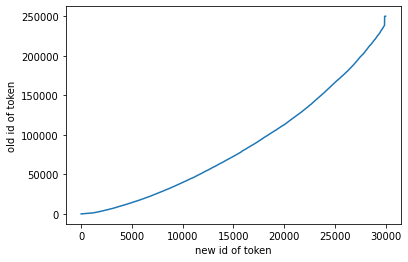

In [42]:
import matplotlib.pyplot as plt
plt.plot(kept_ids)
plt.xlabel('new id of token')
plt.ylabel('old id of token');

### Update the embeddings

In [43]:
import torch

In [44]:
new_size = len(kept_ids)
new_emb = torch.nn.Embedding(new_size, model.shared.embedding_dim)
new_head = torch.nn.Linear(in_features=model.lm_head.in_features, out_features=new_size, bias=False)

In [45]:
for new_id, old_id in enumerate(kept_ids):
    new_emb.weight.data[new_id] = model.shared.weight.data[old_id]
    new_head.weight.data[new_id] = model.lm_head.weight.data[old_id]

In [46]:
model.shared.weight = new_emb.weight
model.lm_head.weight = new_head.weight

The new model has 244M parameters - 42% of the original size. 

In [48]:
print(msize(model), msize(model) / original_size)

244309248 0.4194861110195362


### Update the tokenizer

T5 uses Sentencepiece tokenizer, which is implemented in C and is opaque to Python. 

Fortunately, we can download its model and deploy it into Python using its Protobuf representation. 

https://github.com/google/sentencepiece/issues/121

In [ ]:
!wget https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto

We compile the protobuf description of the sentencepiece model in order to be able to modify it. 

In [51]:
! protoc --python_out=. sentencepiece_model.proto

Now we can serialize the model used by the current tokenizer and open it as a protobuf class. 

In [56]:
import sentencepiece_model_pb2 as spmp
smp = tokenizer.sp_model.serialized_model_proto()
m = spmp.ModelProto()
m.ParseFromString(smp)

print('the loaded model has pieces:', len(m.pieces))
new_pieces = [m.pieces[idx] for idx in kept_ids]
print('the new pieces:', len(new_pieces))

# replace the content of the first 30K pieces
for i, p in enumerate(new_pieces):
    m.pieces[i].piece = p.piece
    m.pieces[i].score = p.score
    m.pieces[i].type = p.type

# drop the remaining pieces
n = len(new_pieces)
for i in trange(len(m.pieces) - n):
    m.pieces.pop(len(m.pieces) - 1)

print(len(m.pieces))
with open('new_sp.model', 'wb') as f:
    f.write(m.SerializeToString())

the loaded model has pieces: 250100
the new pieces: 30000



30000


In [78]:
new_tokenizer = T5Tokenizer('new_sp.model', extra_ids=0)

### Save the model

In [79]:
model.config.__dict__['vocab_size'] = new_size
model.config.__dict__['_name_or_path'] = 'cointegrated/rut5-base'
model.config

T5Config {
  "_name_or_path": "cointegrated/rut5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_num_buckets": 32,
  "tie_word_embeddings": false,
  "tokenizer_class": "T5Tokenizer",
  "transformers_version": "4.5.1",
  "use_cache": true,
  "vocab_size": 30000
}

In [81]:
new_tokenizer.save_pretrained('rut5-base')
model.save_pretrained('rut5-base')

In [82]:
!ls rut5-base -alsh

total 933M
4.0K drwxr-xr-x 2 root root 4.0K Apr 30 21:26 .
4.0K drwxr-xr-x 1 root root 4.0K Apr 30 21:26 ..
4.0K -rw-r--r-- 1 root root  677 Apr 30 21:33 config.json
933M -rw-r--r-- 1 root root 933M Apr 30 21:33 pytorch_model.bin
4.0K -rw-r--r-- 1 root root   65 Apr 30 21:33 special_tokens_map.json
812K -rw-r--r-- 1 root root 809K Apr 30 21:33 spiece.model
4.0K -rw-r--r-- 1 root root  116 Apr 30 21:33 tokenizer_config.json


Now try to load the model

In [83]:
model1 = T5ForConditionalGeneration.from_pretrained('rut5-base')
tokenizer1 = T5Tokenizer.from_pretrained('rut5-base')

The model has not been fine-tuned on any sensible task except filling the gaps. And even this task is performed strangely - the models continues generating when it should have stopped. 

But we hope that after fine-tuning it will be better. But this is the topic of the next story)

In [88]:
inputs = tokenizer1('The <extra_id_0> walks in <extra_id_1> park.', return_tensors='pt')
with torch.no_grad():
    hypotheses = model1.generate(
        **inputs, 
        do_sample=True, top_p=0.95, 
        num_return_sequences=3, 
        repetition_penalty=2.5,
        max_length=32,
    )
for h in hypotheses:
    print(tokenizer1.decode(h))

<pad> <extra_id_0> evening on <extra_id_1> the <extra_id_2> the park</s> <pad> <pad> <pad>
<pad> <extra_id_0> Great <extra_id_1> the <extra_id_2> a <extra_id_3> nature center,</s> <pad>
<pad> <extra_id_0> forest <extra_id_1> this <extra_id_2> a <extra_id_3> summer in the...</s>


In [89]:
inputs = tokenizer1('Красивая <extra_id_0> гуляет <extra_id_1> парку.', return_tensors='pt')
with torch.no_grad():
    hypotheses = model1.generate(
        **inputs, 
        do_sample=True, top_p=0.95, 
        num_return_sequences=3, 
        repetition_penalty=2.5,
        max_length=32,
    )
for h in hypotheses:
    print(tokenizer1.decode(h))

<pad> <extra_id_0> птица <extra_id_1> в <extra_id_2>, <extra_id_3>. Гул <extra_id_4>! Красивый <extra_id_5> молодец</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<pad> <extra_id_0> музыка <extra_id_1> в <extra_id_2> в <extra_id_3> осеннее платье в <extra_id_4> в <extra_id_5> и</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<pad> <extra_id_0> женщина, она <extra_id_1> по <extra_id_2> в <extra_id_3>. Красивый <extra_id_39>! Настроение - красиво во всем лесном</s>


I will save the model on my Google drive to retrieve it later for fine-tuning. 

In [91]:
from google.colab import drive
drive.mount('/gd')

Mounted at /gd


In [92]:
model1.save_pretrained('/gd/MyDrive/models/rut5-base-raw')
tokenizer1.save_pretrained('/gd/MyDrive/models/rut5-base-raw')

('/gd/MyDrive/models/rut5-base-raw/tokenizer_config.json',
 '/gd/MyDrive/models/rut5-base-raw/special_tokens_map.json',
 '/gd/MyDrive/models/rut5-base-raw/spiece.model',
 '/gd/MyDrive/models/rut5-base-raw/added_tokens.json')